<a href="https://www.kaggle.com/code/mukherjeesrijit/us-medical-insurance-project?scriptVersionId=187258203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Step 1: Understand the Data and the Problem

* Read the data
* View the data
* Check the data dimensions
* Check the data type

## Problem

Understand and predict the relationship between medical insurance **charges** (numerical), and the features

1. age (numerical)
2. sex (categorical)
3. bmi (numerical)
4. children (numerical)
5. smoker (categorical)
6. region (categorical)

In [1]:
#loading the libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [2]:
#reading the file
df = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')

# looking into the dataframe
df.head()
print(df.shape)
df.info()

(1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# Step 2: Univariate Sample Distribution of Data

Univariate Sample Distribution helps one to understand how each feature, and the response variable is distributed. This may give insights into data preprocessing for better model performance, and interpretability. One can use 

* histogram for visualizing numerical feature
* count plot for visualizing categorical feature

## Interpretation

* A monotonic log transform on the charges, since there are large values, which may result in unstable optimization. It is not applied here, and basic analysis is performed without log transformation. But it may be implemented as done in ISLR [1]. However, this may result in unknown interpretation of the prediction.

[[1]](https://www.statlearning.com/) (An Introduction to Statistical Learning with Applications in R: ISLR, Chapter 8, 8.1.1 Regression Trees) We use the Hitters data set to predict a baseball player’s Salary based on Years (the number of years that he has played in the major leagues) and Hits (the number of hits that he made in the previous year). We first remove observations that are missing Salary values, and log-transform Salary so that its distribution has more of a typical bell-shape. (Recall that Salary is measured in thousands of dollars.)

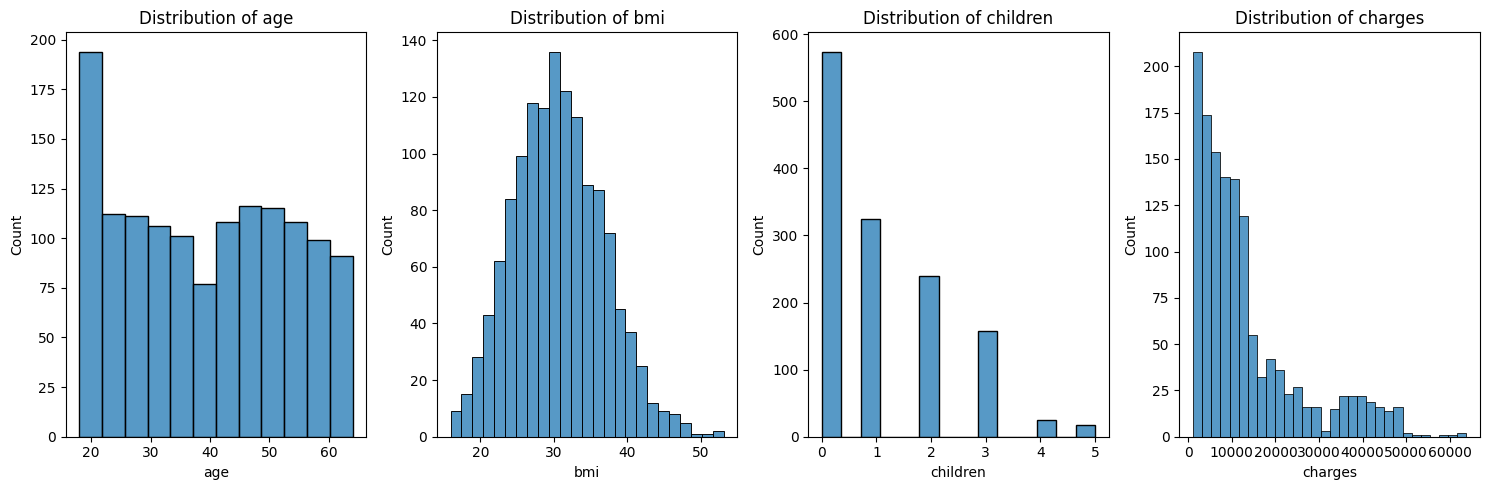

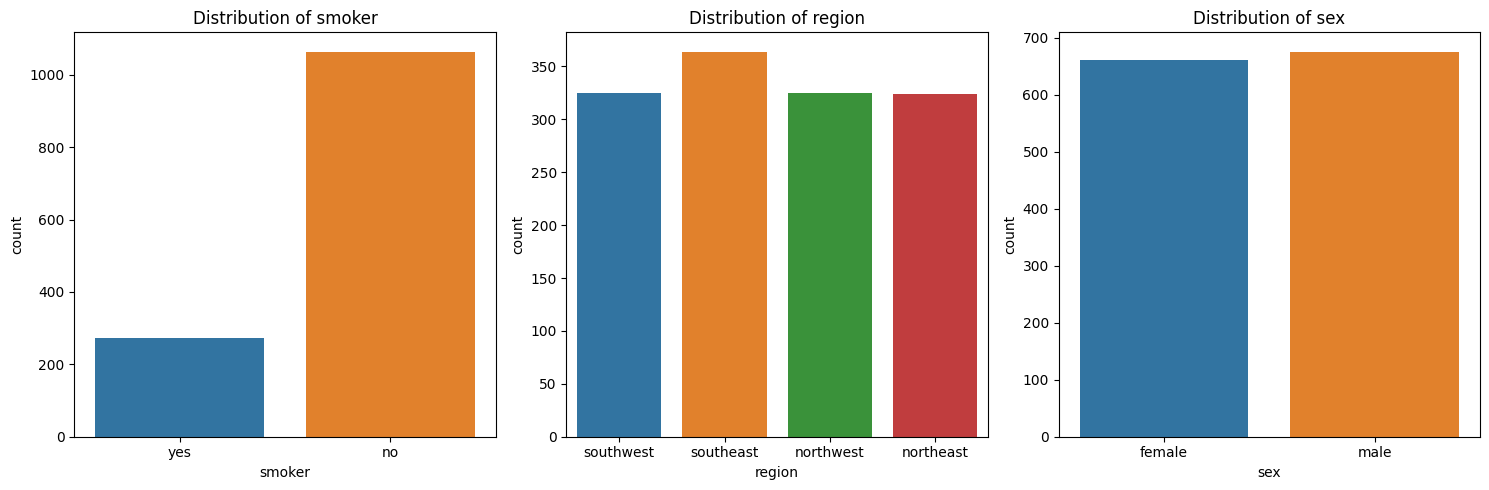

In [3]:
# Suppress the FutureWarning from modules
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Numerical features
numerical_features = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Categorical features
categorical_features = ['smoker', 'region', 'sex']
fig, axes = plt.subplots(1, len(categorical_features), figsize=(15, 5))
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Step 3: Bivariate Sample Relationship of Charges with Features

Bivariate Sample Distribution of response variable may help one helps one to understand how the response variable is individually related to each of the feature. This can help us understand visually, which may be the most important variable for prediction. This can also show multivariate relationship, mostly related to the important features discovered.

* In this problem, you will see a beautiful multivariate relationship, which is coming in the next step.

## Interpretation


* scatterplot for visualizing numerical (charges) vs numerical features
* grouped kernel density plot for visualizing numerical (charges) vs categorical features
* the smoker is the most important variable, since the two kernel densities based on smokers and non smokers, are very distinct
* both the scatter plots of charges vs age and bmi individually shows significant relationships
* there seem to be unknown third variable effect leading to distinct behaviours
* both the age and bmi seems to have multiple distinct processes happening behind the scence. the processes seem to be distinct. 
* hence the best guess is to invoke the smoker variable along with age and bmi, because age shows significant predictive relationship from the grouped kernel density plot
* there seem to be a slight increasing till 2-3 children, and then decreasing after that relationship with charges.
* we will look into a multivariate plot of charges with (age, smoker), (bmi, smoker), and (children, smoker) in the next step.
* other features don't seem to have any effect on the charges.



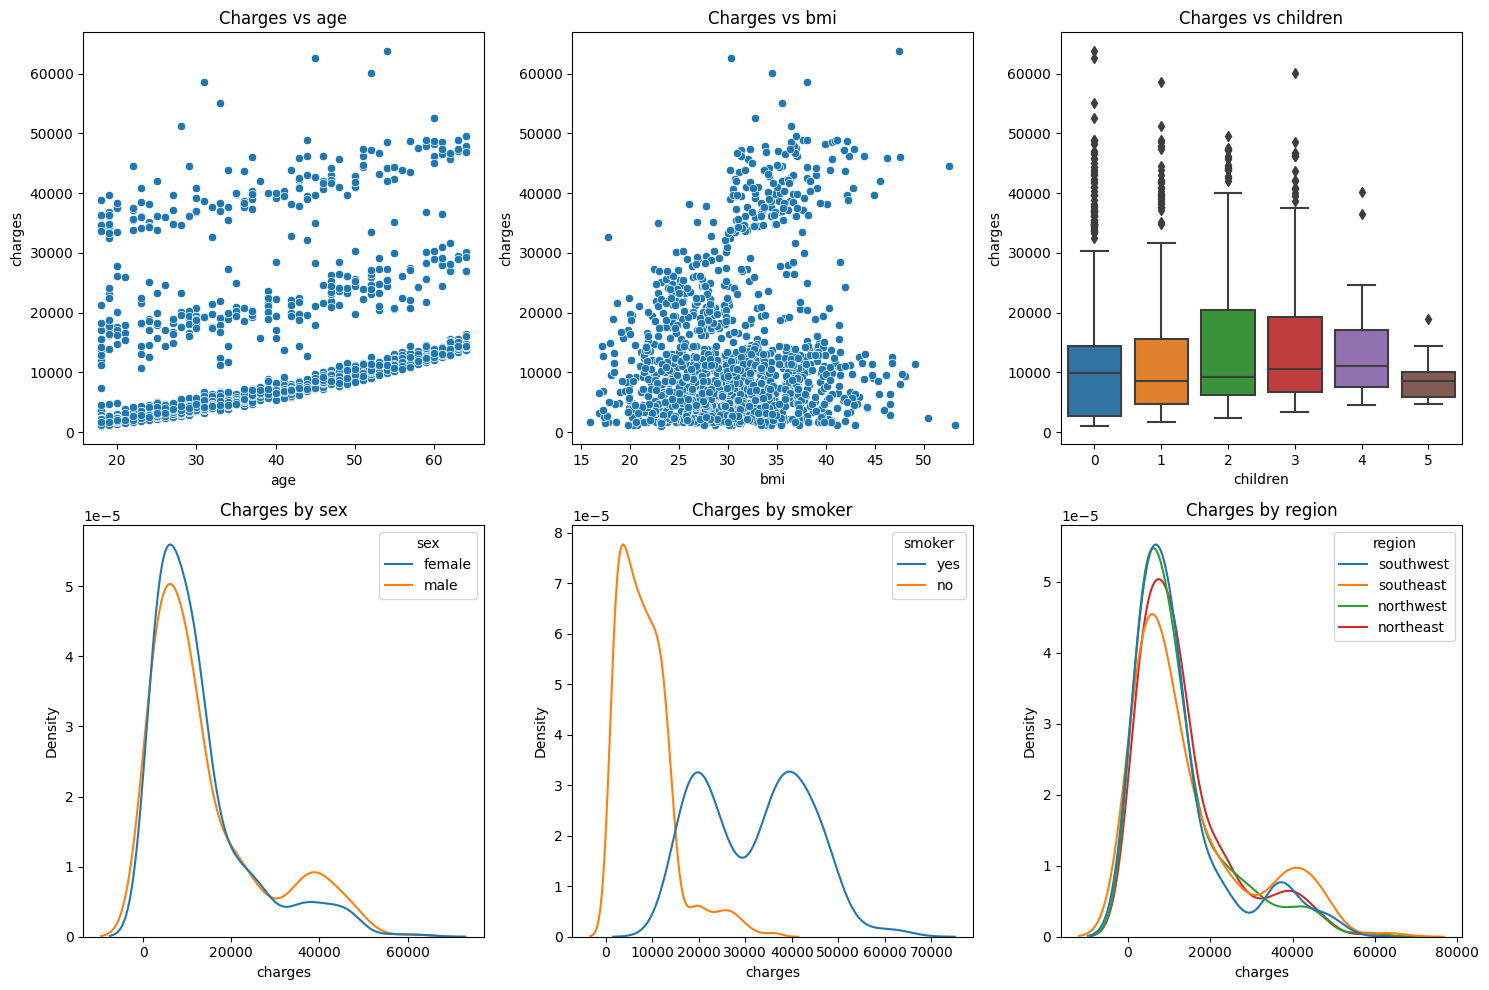

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age', 'bmi']

numerical_discrete = ['children']

# Categorical features
categorical_features = ['sex', 'smoker', 'region']

# Create a figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Iterate over numerical features
for i, num_feature in enumerate(numerical_features):
    # Scatter plots for numerical vs numerical
    sns.scatterplot(x=num_feature, y='charges', data=df, ax=axes[0, i])
    axes[0, i].set_title(f'Charges vs {num_feature}')

for i, num_feature in enumerate(numerical_discrete):
    # Scatter plots for numerical vs numerical
    sns.boxplot(x=num_feature, y='charges', data=df, ax=axes[0, 2])
    axes[0, 2].set_title(f'Charges vs {num_feature}')


# Iterate over categorical features
for i, cat_feature in enumerate(categorical_features):
    # Kernel density plots for numerical vs categorical
    sns.kdeplot(x='charges', hue=cat_feature, data=df, common_norm=False, ax=axes[1, i])
    axes[1, i].set_title(f'Charges by {cat_feature}')

plt.tight_layout()
plt.show()

# Step 4: Sample Relationship of Charges with Features and Smoker (important feature visually)

Since smoker seems to be an important feature for predicting charges and age along with bmi shows important relationship, and segregated clusters of processes inside the individual scatterplots with charges, there seem to be a third variable involved in the scatterplots of age and bmi with charges. I suspec that is smoker. We will understand it based on the multivariate scatter plot of age, bmi, and children with charges, along with the third variable smoker, which colours each point in the scatterplot.

## Interpretation (Visually)

* You can understand that given the **smoker** feature, the other variables show different relationship with charges.
* This is an example of multivariate relationship of the charges response variable with the features. 
* for smoker = yes, charges have similar slope with respect to age visually, as for smoker = no. However, the intercepts may vary. Also, charges vs age relationship have another process going on, which we need to discover.
* Interestly, for smoke = no, bmi shows no relationship, but for smoker = yes, bmi shows a clear increasing relationship, with two different clusters, however inside those clusters, there are no significant relationship between bmi and charges.
* For smoker = no, charges have a slight increasing relationship with children. However, for smoker = yes, charges increases till a certain point (around 2- 3 children), and then again decreases.
* This indeed shows that (smoker, age, bmi, children) together show a strong prediction power and relationship with charges.
* This naturally demands a decision tree, which can help us understand more hidden relationships, and quantify the above visually observed relationships, along with a predictive model.
* In the next steps, we will fit three models: Decision Trees, Random Forests, and Boruta Algorithm with Random Forests to get predictions, and also feature importances, and relationships.

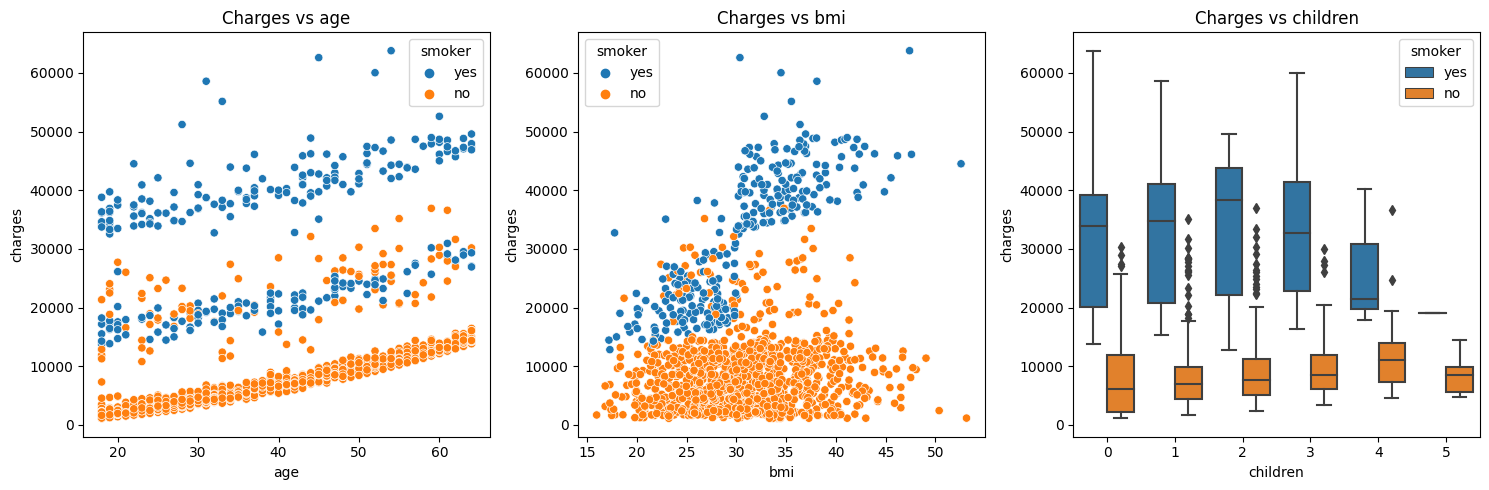

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerical features
numerical_features = ['age', 'bmi']

numerical_discrete = ['children']

# Create a figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over numerical features
for i, num_feature in enumerate(numerical_features):
    # Scatter plots for numerical vs numerical, colored by smoker status
    sns.scatterplot(x=num_feature, y='charges', hue='smoker', data=df, ax=axes[i])
    axes[i].set_title(f'Charges vs {num_feature}')

for i, num_feature in enumerate(numerical_discrete):
    # Scatter plots for numerical vs numerical
    sns.boxplot(x=num_feature, y='charges', hue='smoker', data=df, ax=axes[2])
    axes[2].set_title(f'Charges vs {num_feature}')

plt.tight_layout()
plt.show()

# Step 5: Preparing the Dataset for Model Fitting

The dataset's categorical features are transformed into numerical format with one-hot encoding, and the rest of the numerical features are kept as it is. Then the dataset is partitioned into 80% training data, and 20% test data. 

**Note**: I am not doing any cross validation here. Ideally, for hyperparameter tuning, there should a train, validation, and test dataset. The best model should be selected based on train-validation performance. The final selected model's performance should be presented on the test dataset. I am not following this procedure in this case.

In [6]:
# Categorical and numerical features
categorical_features = ['sex', 'smoker', 'region']
numerical_features = ['age', 'bmi', 'children']

transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

# Transform the features
# Features and target variable
X = transformer.fit_transform(df.drop(['charges'], axis=1))
y = df['charges']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Decision Tree

I choose three metrics (rmse, mae, $R^2$). The decision tree gives

* train error (rmse) ~ 4198
* test error (rmse) ~4512

In [7]:
# Initialize and fit decision tree model
tree = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=10)
tree.fit(X_train, y_train)

# Predict on train data
y_pred_train = tree.predict(X_train)

# Predict on test data
y_pred_test = tree.predict(X_test)

In [8]:
# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 4002.716002910175
MAE: 2281.9071121461766
R^2: 0.8889951268085399

Testing Metrics:
RMSE: 4688.337037142829
MAE: 2672.4909079155414
R^2: 0.8584174958298456


## Step 6.1: Visualizing the Decision Tree, and their Feature Importance

Observe that the 

* first feature is smoker (as expected)
* If smoker = yes, then it is checking if bmi $\leq 29.97$ or not (in the left)
* If smoker = no, then it is checking if age $\leq 42.5$ or not (in the right)
* then more complex relationships are coming, however we see a smoother curve of linear relationship of age and charges
* this shows that decision trees have high variance and lower bias, and have a tendency to overfit
* naturally the importance features in descending order of importance are (smoker, bmi, age), but you may be wondering why "one_hot_smoker_no" and not "one_hot_smoker_yes"?
* in another iteration, it may give one_hot_smoker_yes. they are the same thing, the algorithm randomly selects one.
* also decision trees partition the space into lines parallel to the coordinate axes, and not oblique axes
* this also reminds me of oblique decision trees ([3]  [4]), where the the decision boundaries are oblique, as shown below. this settings makes a lot of sense in this case. let's see if I can implement this here.

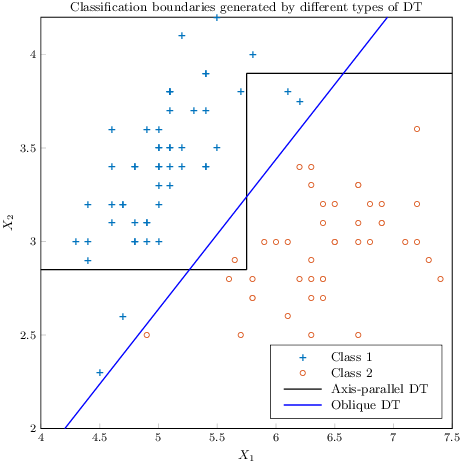

[3] Wickramarachchi, Darshana Chitraka, et al. "HHCART: an oblique decision tree." Computational Statistics & Data Analysis 96 (2016): 12-23.

[4] Murthy, Sreerama K., Simon Kasif, and Steven Salzberg. "A system for induction of oblique decision trees." Journal of artificial intelligence research 2 (1994): 1-32.

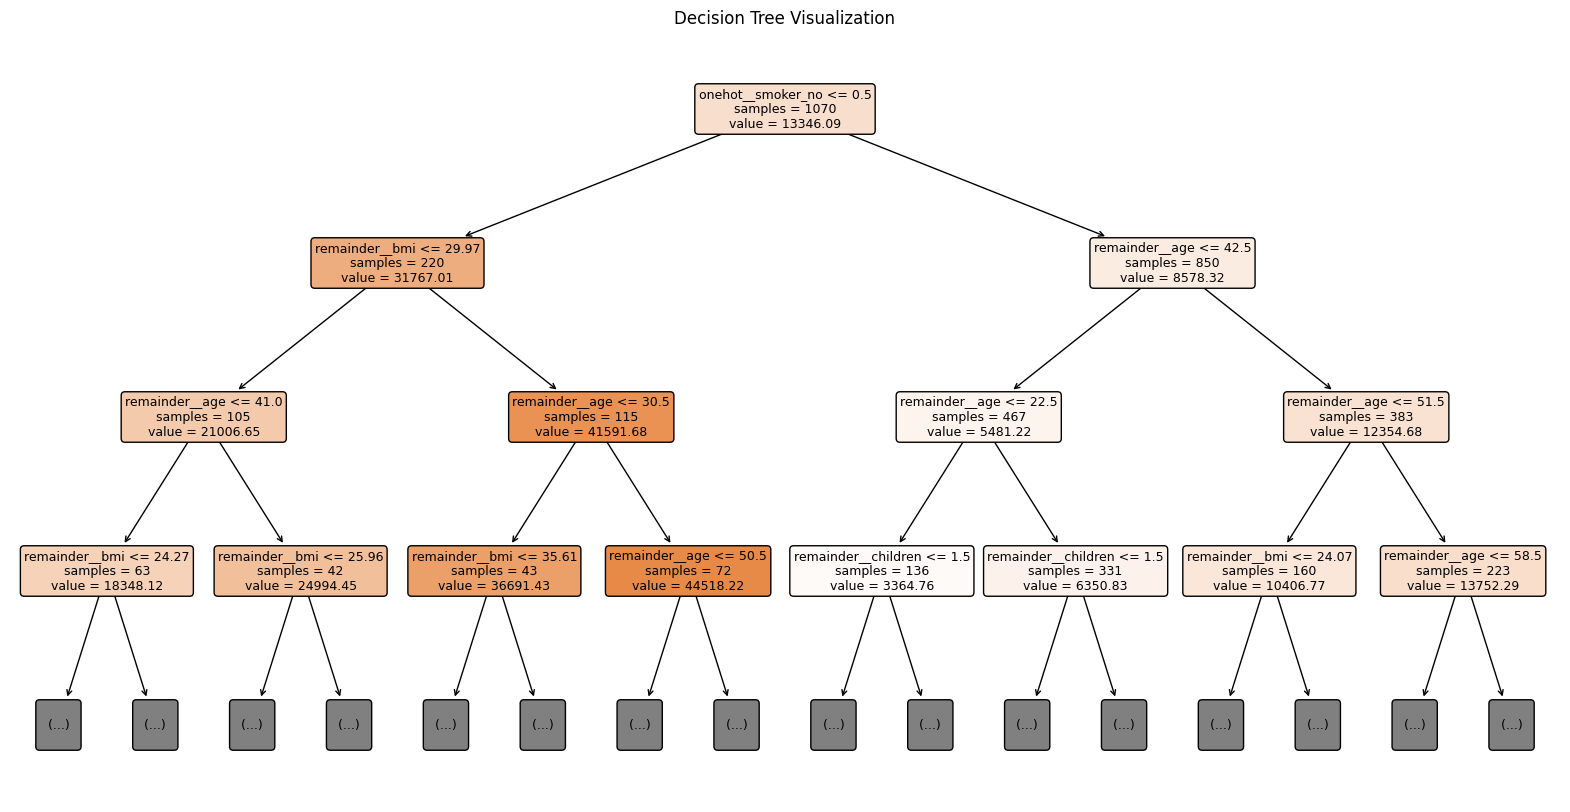

In [9]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
plt.figure(figsize=(20, 10))

# Customize the plot_tree parameters
plot_tree(tree, 
          feature_names=transformer.get_feature_names_out(), 
          filled=True, 
          rounded=True, 
          precision=2, 
          fontsize=9, 
          max_depth=3, 
          proportion=False, 
          impurity=False)

plt.title("Decision Tree Visualization")
plt.show()

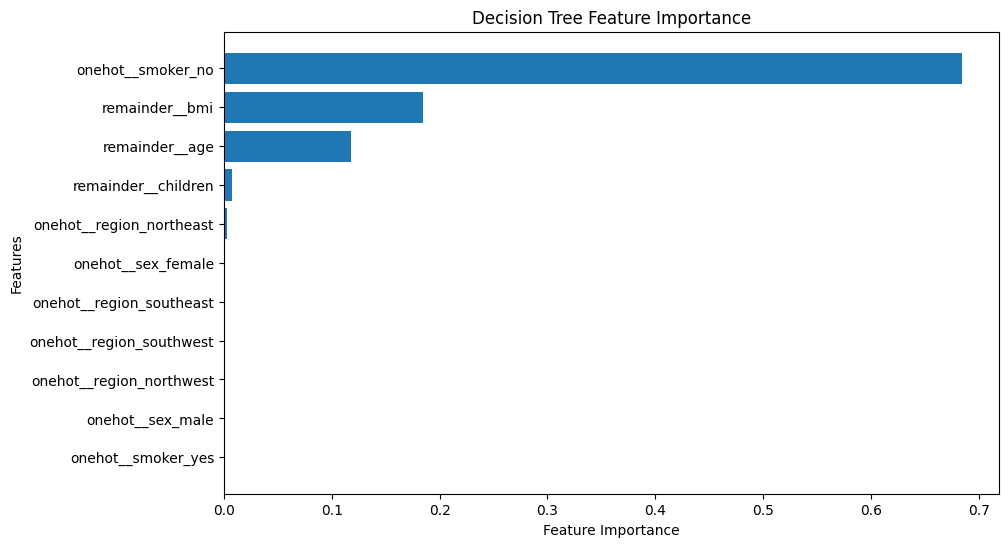

In [10]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
# Get feature importances
importances = tree.feature_importances_
feature_names = transformer.get_feature_names_out()

# Sort the feature importances and corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Step 7: Random Forest

I choose three metrics (rmse, mae, $R^2$). The random forest gives

* train error (rmse) ~ 1911 (much lower than decision tree)
* test error (rmse) ~ 4590 (similar to decision tree)

The random forest feature importance takes the mean of the feature importances of multiple trees. Hence both one_hot_smoker_yes, and one_hot_smoker_no are in the plot, because in different trees, different ones have come up. The rest is similar to that we have discovered from decision trees.

In [11]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed

# Train the model
rf_model.fit(X_train, y_train)

# Predict on train and test data
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

In [12]:
# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 1911.1746477918875
MAE: 1045.1401466105851
R^2: 0.9746934325804264

Testing Metrics:
RMSE: 4590.47276006361
MAE: 2545.27659835908
R^2: 0.8642665871830159


In [13]:
# we will later use this for prediction interval

Z = 1.96

# Function to calculate the variance for prediction intervals
def random_forest_inf_jack(rf, X):
    preds = np.array([tree.predict(X) for tree in rf.estimators_])
    y_hat = preds.mean(axis=0)
    var_hat = preds.var(axis=0, ddof=1)
    return y_hat, var_hat

# Calculate the variance
y_hat_rf, var_hat_rf = random_forest_inf_jack(rf_model, X_test)
se_rf = np.sqrt(var_hat_rf)

# Plot the fit
df_rf = pd.DataFrame({'y': y_test, 'y_hat': y_hat_rf, 'se': se_rf, 'model': 'clusterrf'})

# Calculate confidence intervals for both models
df_rf['lower_ci'] = df_rf['y_hat'] - Z * df_rf['se']
df_rf['upper_ci'] = df_rf['y_hat'] + Z * df_rf['se']

Selected Features: ['onehot__smoker_no', 'remainder__bmi', 'onehot__smoker_yes', 'remainder__age', 'remainder__children']


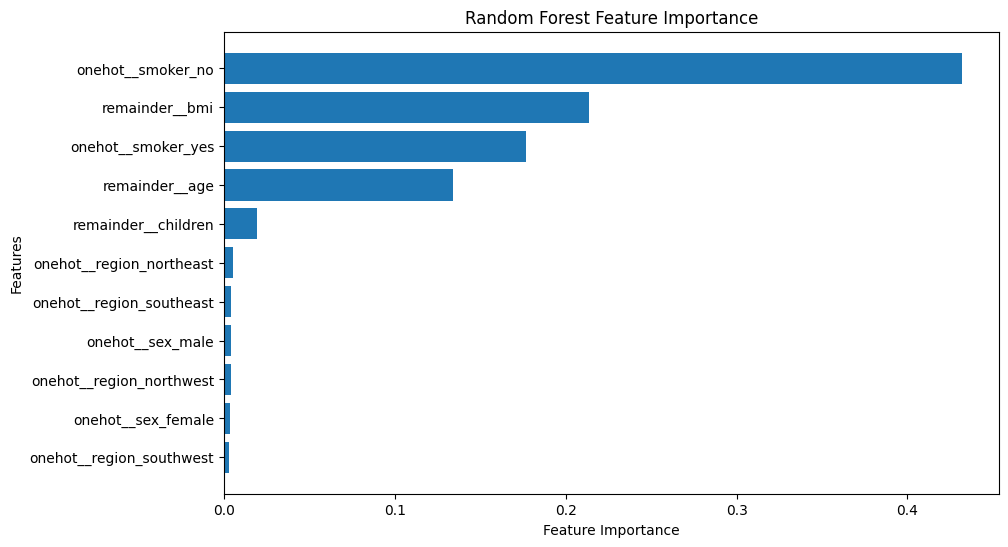

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Use get_feature_names_out() to get names of transformed features
feature_names = transformer.get_feature_names_out()

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Create DataFrame with feature importances
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Select top k features (adjust k as needed)
k = 5  # Example: select top 5 features
selected_features = feature_importances['Feature'][:k].tolist()

# Print the selected features
print("Selected Features:", selected_features)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Step 8: More Data Visualization and Data Exploration

* The decision tree shows the feature relationship with the 
* The very fact that bmi $\geq 29.97$ and $< 29.97$ is coming out to be an important feature for decision making, while [2] shows that 29.9/30.00 onwards, it falls in obese range is quite interesting.
* We will use this to create a new dataframe, and discover some interesting aspects.
* It can be easily understood that for smoker = yes, bmi = high and bmi = low create two different behaviours and starting points for charges vs ages relationship.
* The remaining cluster for smoker = no, there are two different processes happening, but no other variable seem to explain that significant difference, and not bmi as shown in the pics below.
* So, I decided to fit a gaussian mixture model with 2 clusters to fit the smoker = no dataframe, and it turns out that, the visual clusters indeed exist.
* I added two columns to the actual dataframe called bmi_status = high/low, and cluster = 0/1/-1 which is happening due to an unknown feature, indicating that the data is incomplete.
* In the next part, I will try to understand whether there is any relationship of the features with the clusters quantitatively using another decision tree, and check it's performance metric.

[[2]](https://www.cdc.gov/healthyweight/assessing/index.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obese%20range.): If your BMI is less than 18.5, it falls within the underweight range.
If your BMI is 18.5 to 24.9, it falls within the Healthy Weight range.
If your BMI is 25.0 to 29.9, it falls within the overweight range.
If your BMI is 30.0 or higher, it falls within the obese range.

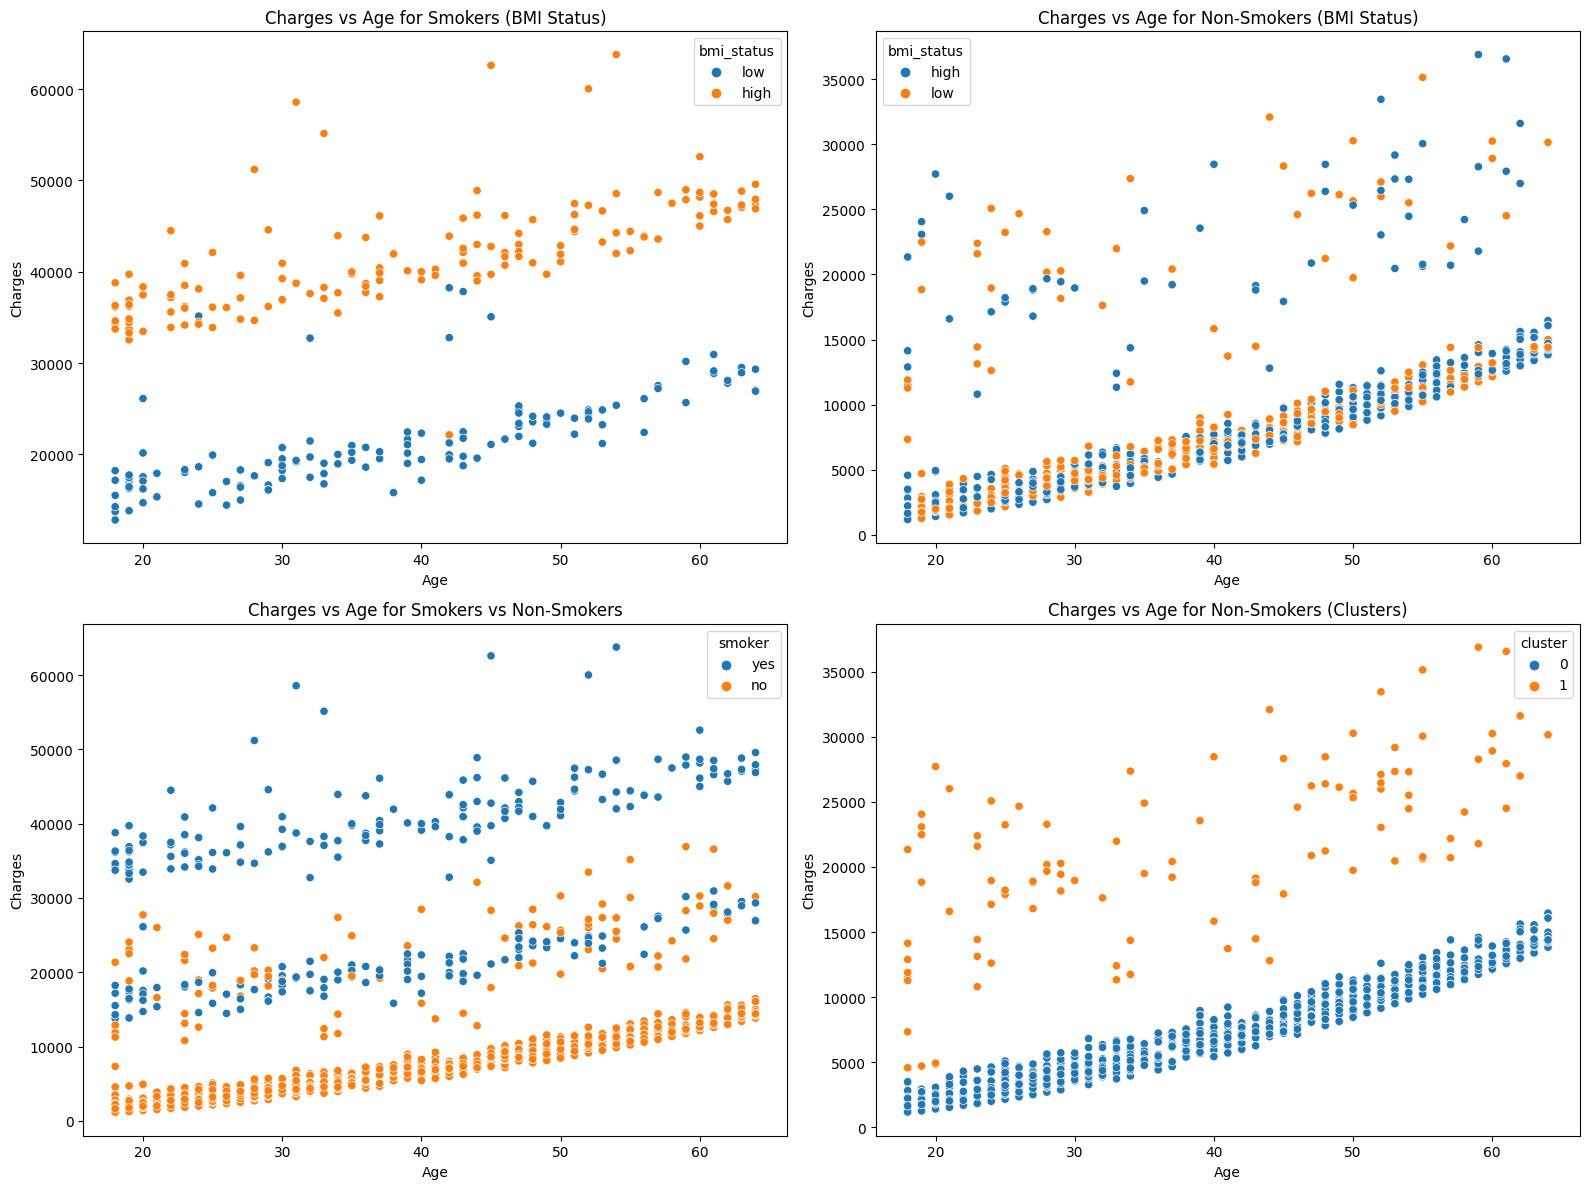

In [15]:
# Load the dataset
df = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')

# Create a new column 'bmi_status'
df['bmi_status'] = df['bmi'].apply(lambda x: 'high' if x >= 29.97 else 'low')

# Initialize the cluster column with -1
df['cluster'] = -1

# Select features for clustering (age and charges) for non-smokers
non_smokers_df = df[df['smoker'] == 'no']
X = non_smokers_df[['age', 'charges']]

# Initialize GaussianMixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model and predict cluster labels
non_smokers_df = non_smokers_df.copy()  # Create a copy to avoid SettingWithCopyWarning
non_smokers_df['cluster'] = gmm.fit_predict(X)

# Update the cluster column in the original dataframe
df.loc[non_smokers_df.index, 'cluster'] = non_smokers_df['cluster']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot for smokers with BMI status
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=df[df['smoker'] == 'yes'], ax=axes[0, 0])
axes[0, 0].set_title('Charges vs Age for Smokers (BMI Status)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Charges')

# Plot for non-smokers with BMI status
sns.scatterplot(x='age', y='charges', hue='bmi_status', data=df[df['smoker'] == 'no'], ax=axes[0, 1])
axes[0, 1].set_title('Charges vs Age for Non-Smokers (BMI Status)')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Charges')

# Plot for smokers vs non-smokers
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Charges vs Age for Smokers vs Non-Smokers')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Charges')

# Plot for non-smokers with cluster
sns.scatterplot(x='age', y='charges', hue='cluster', data=df[df['smoker'] == 'no'], ax=axes[1, 1])
axes[1, 1].set_title('Charges vs Age for Non-Smokers (Clusters)')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Charges')

plt.tight_layout()
plt.show()

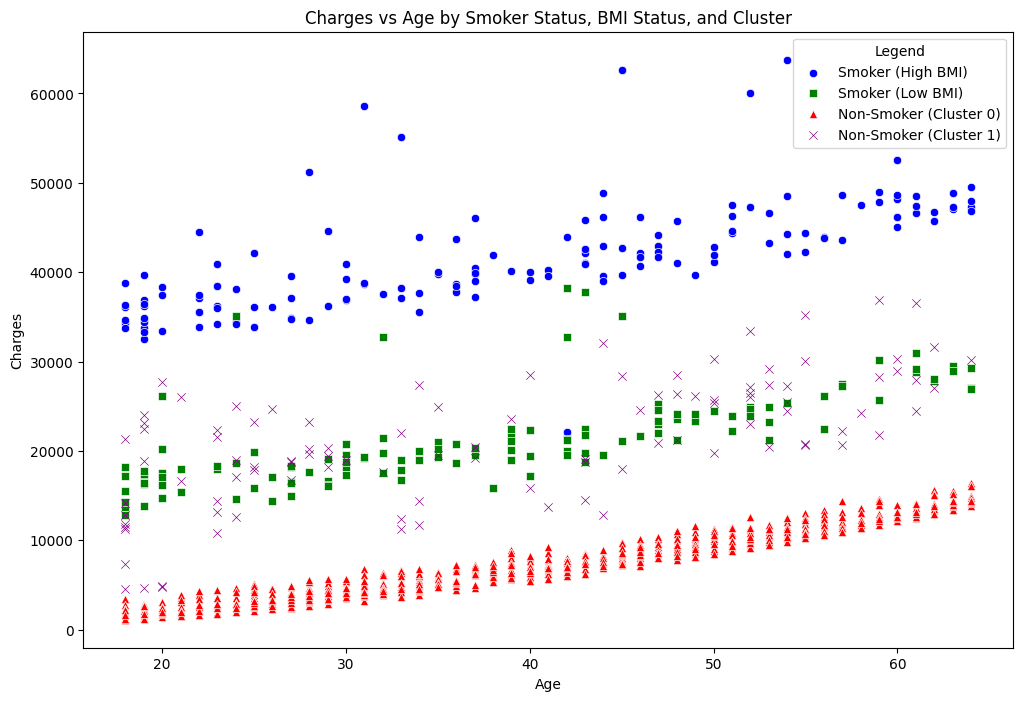

In [16]:
# Create a single plot with different categories using distinct colors
plt.figure(figsize=(12, 8))

# Plot for smoker with high BMI (blue)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')],
    color='blue', marker='o', label='Smoker (High BMI)'
)

# Plot for smoker with low BMI (red)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'low')],
    color='green', marker='s', label='Smoker (Low BMI)'
)

# Plot for non-smokers with cluster 0 (green)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'no') & (df['cluster'] == 0)],
    color='red', marker='^', label='Non-Smoker (Cluster 0)'
)

# Plot for non-smokers with cluster 1 (purple)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'no') & (df['cluster'] == 1)],
    color='purple', marker='x', label='Non-Smoker (Cluster 1)'
)

plt.title('Charges vs Age by Smoker Status, BMI Status, and Cluster')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Legend', loc='upper right')
plt.show()

# Step 9: Understand the algorithmic significance of missing feature

* I fit four distinct linear regression with mae loss to each of those clusters.
* They fit perfectly fine, and show similar trend with age. This support the fact that the purple cross (Non Smoker Cluster 1) which has really high insurance charges starting from 9k around age 0, shows some insights into that fact that this cluster may be related to a missing feature attributing to high insurance charge. One guess is disability or some disease feature, which is not reported in the simulated dataset also since the variance is a bit high, showing variability in the different disease / disability type.

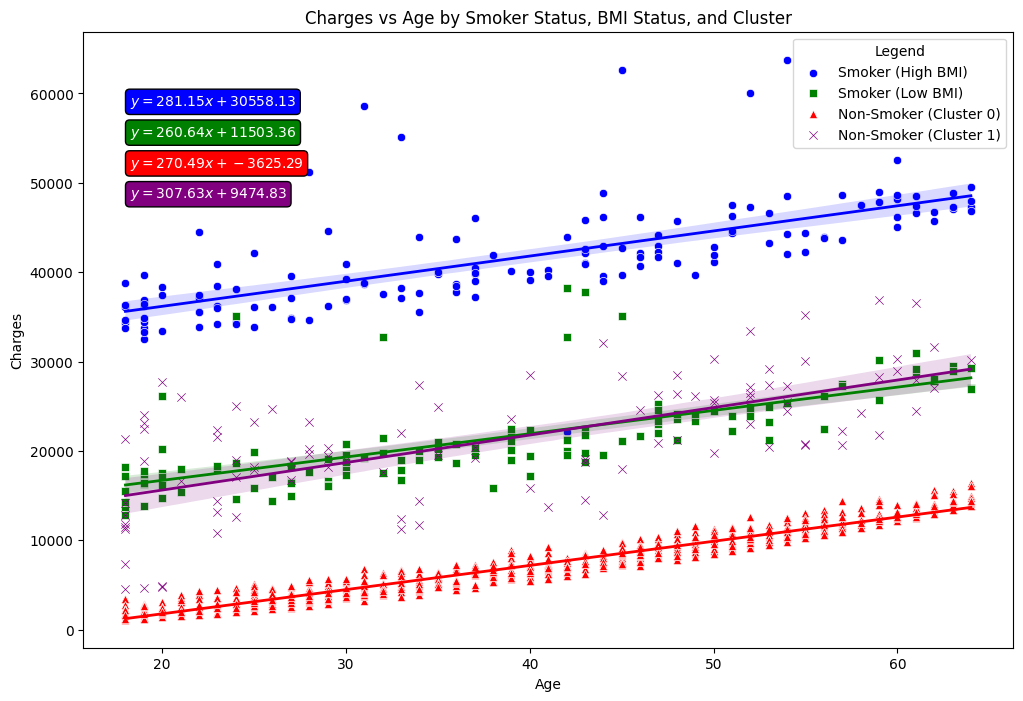

In [17]:
# Define a function to add the regression line and equation
def plot_regression_line(data, x, y, label, ax, color):
    X = data[[x]].values
    y = data[y].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    
    sns.regplot(x=x, y=y, data=data, scatter=False, ax=ax, color=color, line_kws={"linewidth": 2})

    # Calculate equation of line
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Annotate the equation on the plot
    ax.text(
        0.05, 0.95 - 0.05 * label, f'$y = {slope:.2f}x + {intercept:.2f}$', color='white',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.3', facecolor=color, edgecolor='black')
    )

# Create a single plot with different categories using distinct colors
fig, ax = plt.subplots(figsize=(12, 8))

# Plot for smoker with high BMI (blue)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')],
    color='blue', marker='o', label='Smoker (High BMI)', ax=ax
)
plot_regression_line(df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'high')], 'age', 'charges', 1, ax, 'blue')

# Plot for smoker with low BMI (green)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'low')],
    color='green', marker='s', label='Smoker (Low BMI)', ax=ax
)
plot_regression_line(df[(df['smoker'] == 'yes') & (df['bmi_status'] == 'low')], 'age', 'charges', 2, ax, 'green')

# Plot for non-smokers with cluster 0 (red)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'no') & (df['cluster'] == 0)],
    color='red', marker='^', label='Non-Smoker (Cluster 0)', ax=ax
)
plot_regression_line(df[(df['smoker'] == 'no') & (df['cluster'] == 0)], 'age', 'charges', 3, ax, 'red')

# Plot for non-smokers with cluster 1 (purple)
sns.scatterplot(
    x='age', y='charges',
    data=df[(df['smoker'] == 'no') & (df['cluster'] == 1)],
    color='purple', marker='x', label='Non-Smoker (Cluster 1)', ax=ax
)
plot_regression_line(df[(df['smoker'] == 'no') & (df['cluster'] == 1)], 'age', 'charges', 4, ax, 'purple')

plt.title('Charges vs Age by Smoker Status, BMI Status, and Cluster')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Legend', loc='upper right')
plt.show()

# Step 10: What explains the new feature?

The goal is to predict the cluster information from the non-informative features like sex, region, and children. It turns out that it can indeed predict the cluster information from these features at 73% accuracy. However it is not enough to get to the required regression result. However, I do believe that there is some missing feature, that explain all the different clusters.

In [18]:
# Categorical and numerical features
categorical_features = ['sex', 'region']
numerical_features = ['age', 'bmi', 'children']

# Filter the dataframe where smoker = 'no'
# df_no_smoker = df[df['smoker'] == 'no']

# Initialize ColumnTransformer
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

# Transform the features for smoker = 'no'
X = transformer.fit_transform(df.drop(['cluster', 'bmi', 'bmi_status', 'charges', 'smoker', 'age'], axis=1))
y = df['cluster']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=5,  # Example hyperparameter, adjust as needed
    min_samples_split=2,  # Example hyperparameter, adjust as needed
    min_samples_leaf=1,  # Example hyperparameter, adjust as needed
    random_state=42
)

# Fit the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict on the training data
train_predictions = dt_classifier.predict(X_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Predict on the testing data
test_predictions = dt_classifier.predict(X_test)

# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Testing Accuracy: {test_accuracy:.2f}")

Training Accuracy: 0.72
Testing Accuracy: 0.73


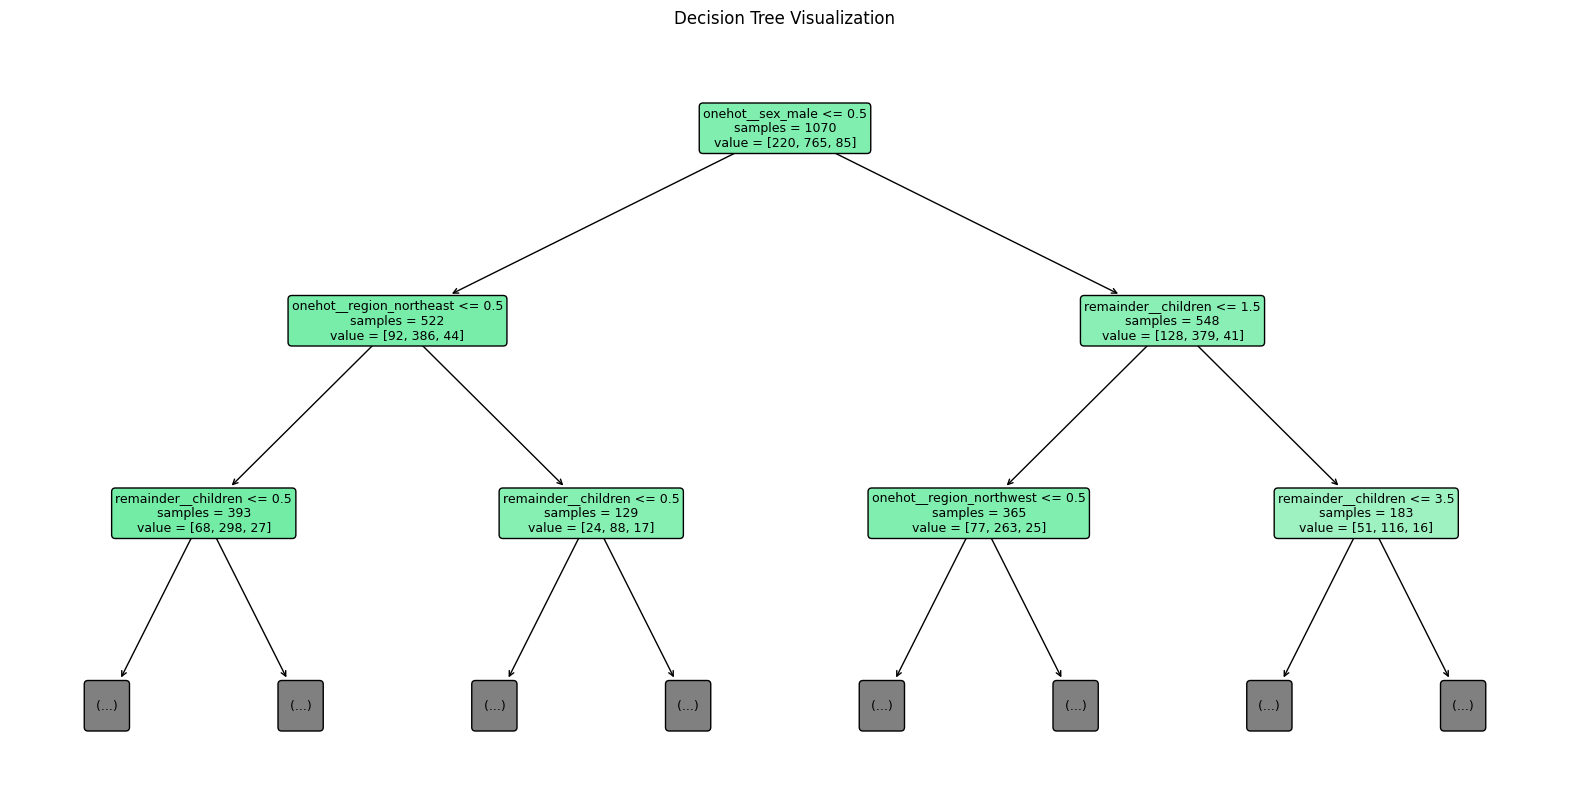

In [19]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
plt.figure(figsize=(20, 10))

# Customize the plot_tree parameters
plot_tree(dt_classifier, 
          feature_names=transformer.get_feature_names_out(), 
          filled=True, 
          rounded=True, 
          precision=2, 
          fontsize=9, 
          max_depth=2, 
          proportion=False, 
          impurity=False)

plt.title("Decision Tree Visualization")
plt.show()

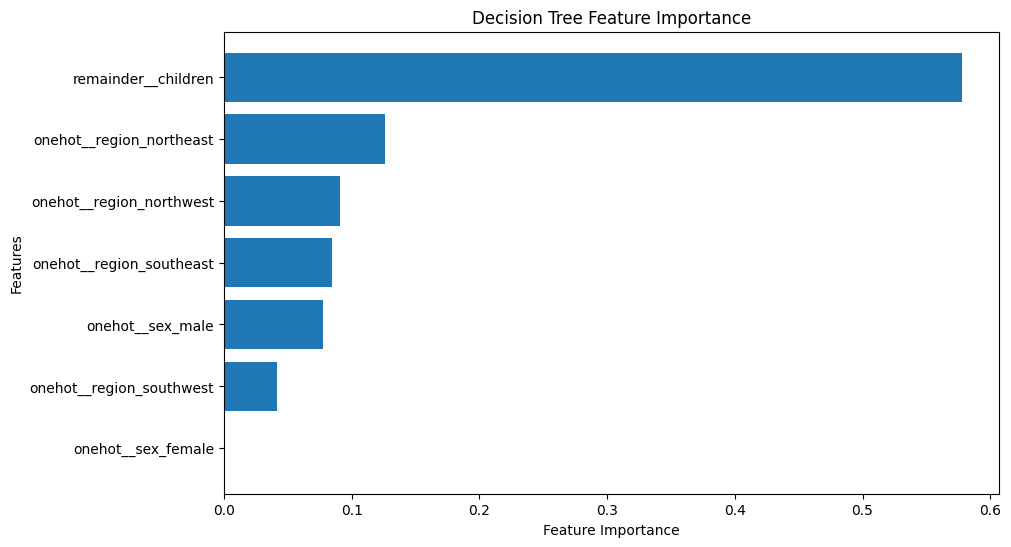

In [20]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
# Get feature importances
importances = dt_classifier.feature_importances_
feature_names = transformer.get_feature_names_out()

# Sort the feature importances and corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Step 11: Does new feature improve the performance?

The new cluster does improve the performance drastically from 

* train error (rmse) ~ 1911 to 2186 (increases)
* test error (rmse) ~ 4590 to 2635 (decreases a lot)
* similar performance improvements have been observed by random forest too, on this new engineered feature.

* This explains the importance of this new feature of cluster. In fact that the most important feature, mostly because it contains both the smoker, and the cluster information together.


In [21]:
# Load the dataset
df = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')

# Create a new column 'bmi_status'
df['bmi_status'] = df['bmi'].apply(lambda x: 'high' if x >= 29.97 else 'low')

# Initialize the cluster column with -1
df['cluster'] = -1

# Select features for clustering (age and charges) for non-smokers
non_smokers_df = df[df['smoker'] == 'no']
X = non_smokers_df[['age', 'charges']]

# Initialize GaussianMixture with 2 components
gmm = GaussianMixture(n_components=2, random_state=42)

# Fit the model and predict cluster labels
non_smokers_df = non_smokers_df.copy()  # Create a copy to avoid SettingWithCopyWarning
non_smokers_df['cluster'] = gmm.fit_predict(X)

# Update the cluster column in the original dataframe
df.loc[non_smokers_df.index, 'cluster'] = non_smokers_df['cluster']# Categorical and numerical features
categorical_features = ['sex', 'smoker', 'region', 'cluster']
numerical_features = ['age', 'bmi', 'children']

transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Keep numerical features as is
)

# Transform the features
# Features and target variable
X = transformer.fit_transform(df.drop(['charges','bmi_status'], axis=1))
y = df['charges']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Initialize and fit decision tree model
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
tree.fit(X_train, y_train)

# Predict on train data
y_pred_train = tree.predict(X_train)

# Predict on test data
y_pred_test = tree.predict(X_test)

In [23]:
# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 2186.522083082082
MAE: 1088.2387129884273
R^2: 0.966876194501514

Testing Metrics:
RMSE: 2635.2787947583997
MAE: 1292.0921830436148
R^2: 0.9552673038976085


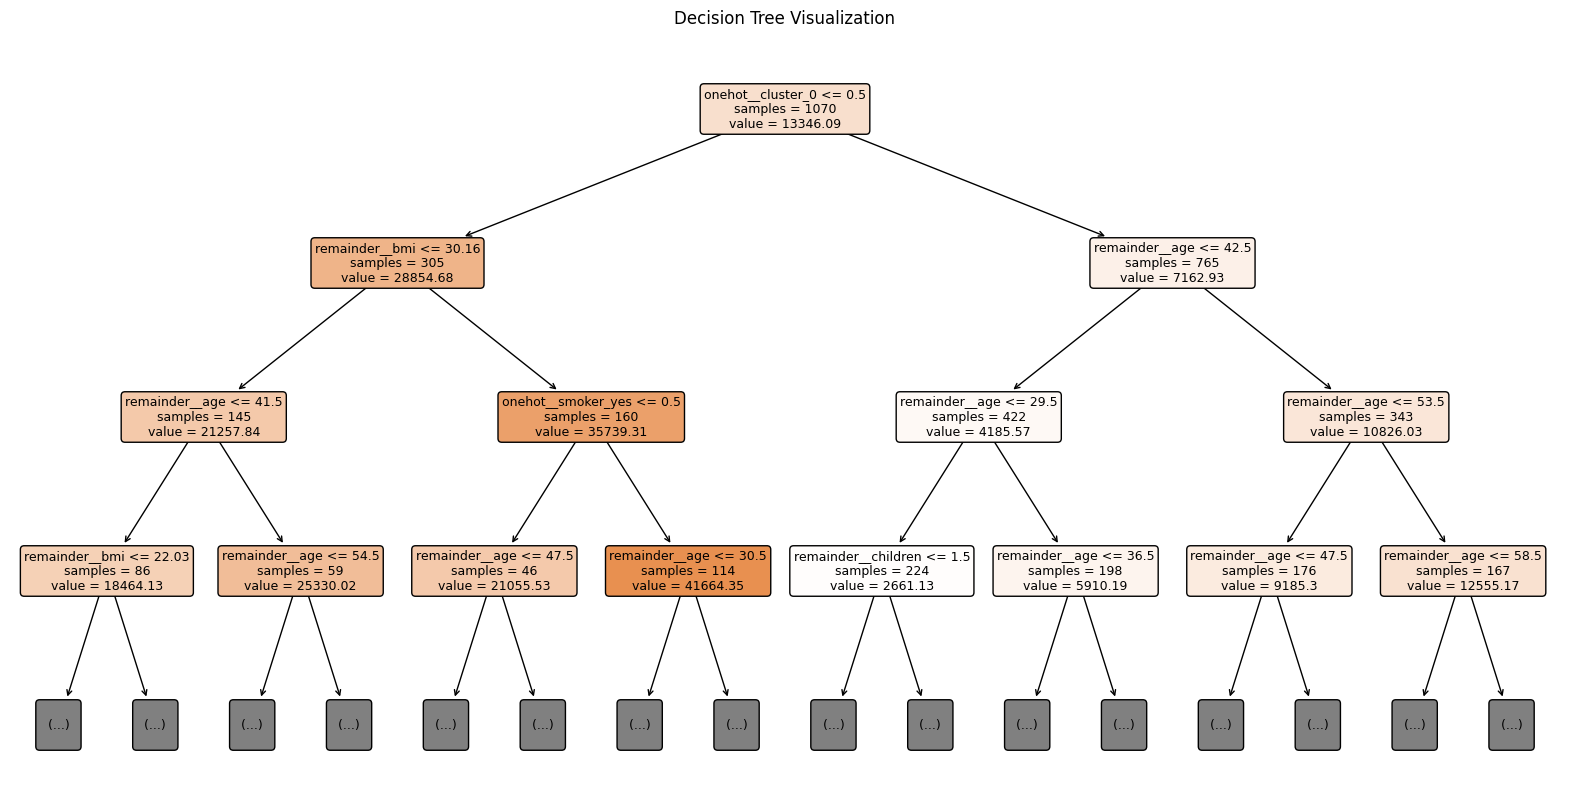

In [24]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
plt.figure(figsize=(20, 10))

# Customize the plot_tree parameters
plot_tree(tree, 
          feature_names=transformer.get_feature_names_out(), 
          filled=True, 
          rounded=True, 
          precision=2, 
          fontsize=9, 
          max_depth=3, 
          proportion=False, 
          impurity=False)

plt.title("Decision Tree Visualization")
plt.show()

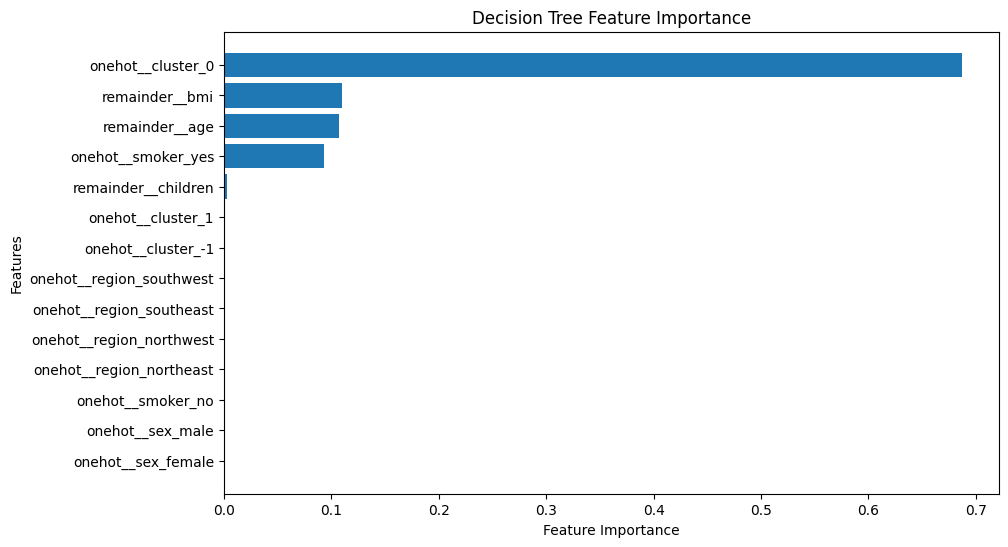

In [25]:
# Assuming 'tree' is your trained model and 'transformer' is your feature transformer
# Get feature importances
importances = tree.feature_importances_
feature_names = transformer.get_feature_names_out()

# Sort the feature importances and corresponding feature names
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [26]:
# Initialize Random Forest model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust hyperparameters as needed

# Train the model
rf_model1.fit(X_train, y_train)

# Predict on train and test data
y_pred_train = rf_model1.predict(X_train)
y_pred_test = rf_model1.predict(X_test)# Evaluate model performance on training data
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print('Training Metrics:')
print('RMSE:', rmse_train)
print('MAE:', mae_train)
print('R^2:', r2_train)

# Evaluate model performance on testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print('\nTesting Metrics:')
print('RMSE:', rmse_test)
print('MAE:', mae_test)
print('R^2:', r2_test)

Training Metrics:
RMSE: 961.0919866522255
MAE: 372.19374771654253
R^2: 0.9936002589387318

Testing Metrics:
RMSE: 2511.001495760083
MAE: 1005.5181009958962
R^2: 0.959386924124121


In [27]:
# we will later use this for prediction interval

# Function to calculate the variance for prediction intervals
def random_forest_inf_jack(rf, X):
    preds = np.array([tree.predict(X) for tree in rf.estimators_])
    y_hat = preds.mean(axis=0)
    var_hat = preds.var(axis=0, ddof=1)
    return y_hat, var_hat

# Calculate the variance
y_hat_rf1, var_hat_rf1 = random_forest_inf_jack(rf_model1, X_test)
se_rf1 = np.sqrt(var_hat_rf1)

# Plot the fit
df_rf1 = pd.DataFrame({'y': y_test, 'y_hat': y_hat_rf1, 'se': se_rf1, 'model': 'clusterrf'})

# Define Z-score for 95% confidence interval
Z = 1.96

df_rf1['lower_ci'] = df_rf1['y_hat'] - Z * df_rf1['se']
df_rf1['upper_ci'] = df_rf1['y_hat'] + Z * df_rf1['se']

# Step 11: Prediction Interval for the Random Forest Models

The prediction interval for each prediction is created by:

- **Mean Predictions** ($ \hat{y} $):
  Using each tree in the Random Forest to make predictions. Calculating the mean and variance of these predictions.Calculated from the Random Forest models for each data point.

- **Standard Errors (SE)**:
  Measure of uncertainty in predictions.

- **Z-score**:
  Chosen based on desired confidence level (e.g., $ Z = 1.96 $ for 95% confidence).

- **Confidence Intervals**:
  Calculated as $ \hat{y} \pm Z \times SE $, where:
  - $ \hat{y} $ is the mean prediction.
  - $ Z $ is the Z-score corresponding to the desired confidence level.
  - $ SE $ is the standard error of the prediction.


- **Plotting**:
  Error bars (`errorbar`) and shaded intervals (`fill_between`) are plotted to visualize the uncertainty in predictions.


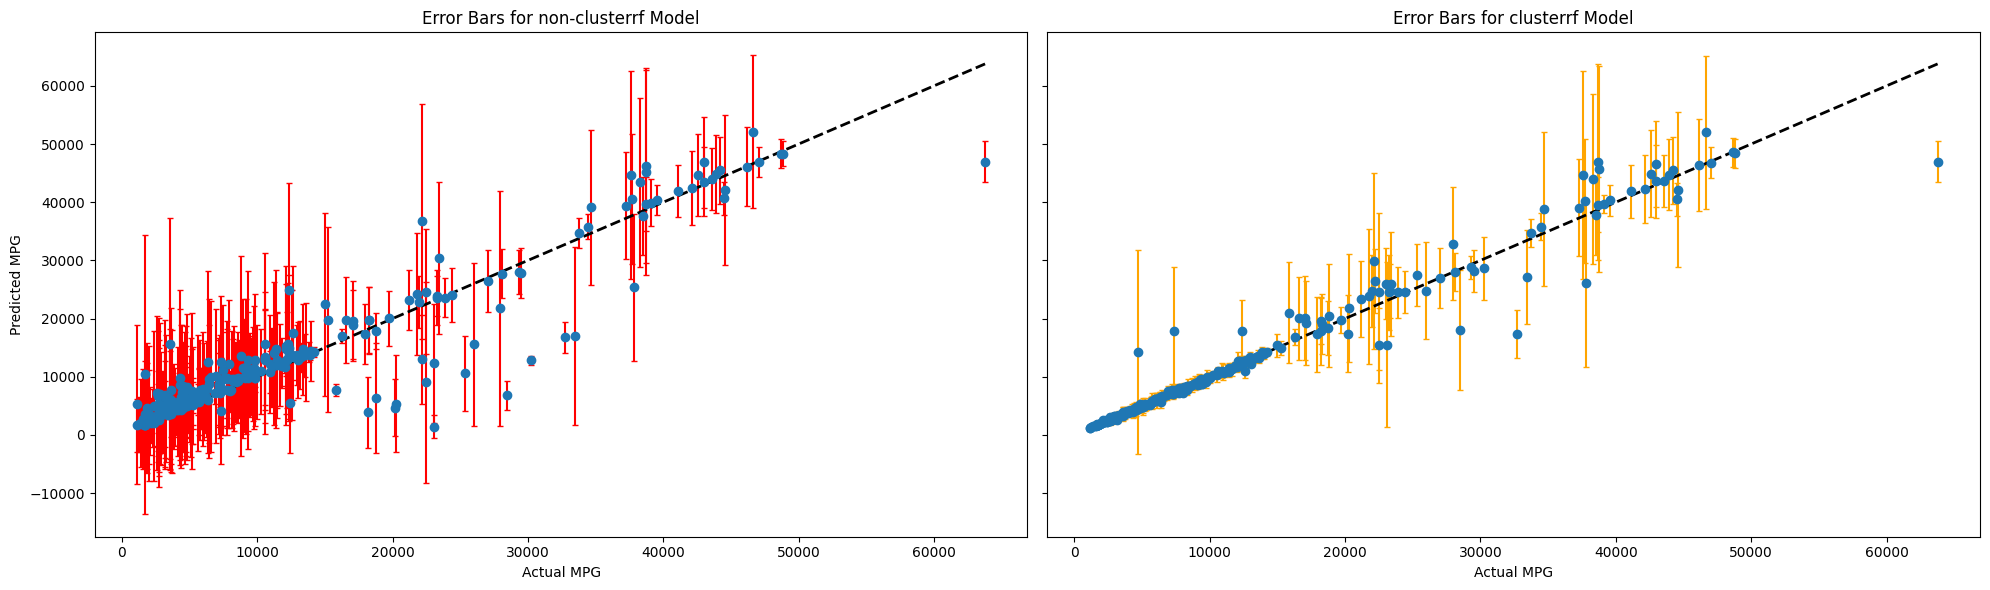

In [28]:
# Combine DataFrames
df_combined = pd.concat([df_rf, df_rf1])

# Plot error bars for Random Forest predictions side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# Plot for non-clusterrf model
sns.scatterplot(ax=axes[0], x='y', y='y_hat', data=df_rf, color='blue')
axes[0].errorbar(df_rf['y'], df_rf['y_hat'], yerr=Z*df_rf['se'], fmt='o', ecolor='red', capsize=2)
# axes[0].fill_between(df_rf['y'], df_rf['lower_ci'], df_rf['upper_ci'], color='blue', alpha=0.2)
axes[0].plot([df_rf['y'].min(), df_rf['y'].max()], [df_rf['y'].min(), df_rf['y'].max()], 'k--', lw=2)
axes[0].set_xlabel("Actual MPG")
axes[0].set_ylabel("Predicted MPG")
axes[0].set_title("Error Bars for non-clusterrf Model")

# Plot for clusterrf model
sns.scatterplot(ax=axes[1], x='y', y='y_hat', data=df_rf1, color='orange')
axes[1].errorbar(df_rf1['y'], df_rf1['y_hat'], yerr=Z*df_rf1['se'], fmt='o', ecolor='orange', capsize=2)
# axes[1].fill_between(df_rf1['y'], df_rf1['lower_ci'], df_rf1['upper_ci'], color='orange', alpha=0.2)
axes[1].plot([df_rf1['y'].min(), df_rf1['y'].max()], [df_rf1['y'].min(), df_rf1['y'].max()], 'k--', lw=2)
axes[1].set_xlabel("Actual MPG")
axes[1].set_ylabel("Predicted MPG")
axes[1].set_title("Error Bars for clusterrf Model")

plt.tight_layout()
plt.show()

# Step 11: Fitting a Grouped Linear Regression Method

* This is exactly what I wanted to do. I wanted to distribute them into sections based on bmi, and cluster information.
* Then, I wanted to apply linear regression, in each, and check the performance.
* It turns out that the result is similar to the decision tree, and random forest, with more insights of how the charges change with age. 
* This is the power of data visualization and understanding the data in a better way.

We have already done a visual plot of this before here below.

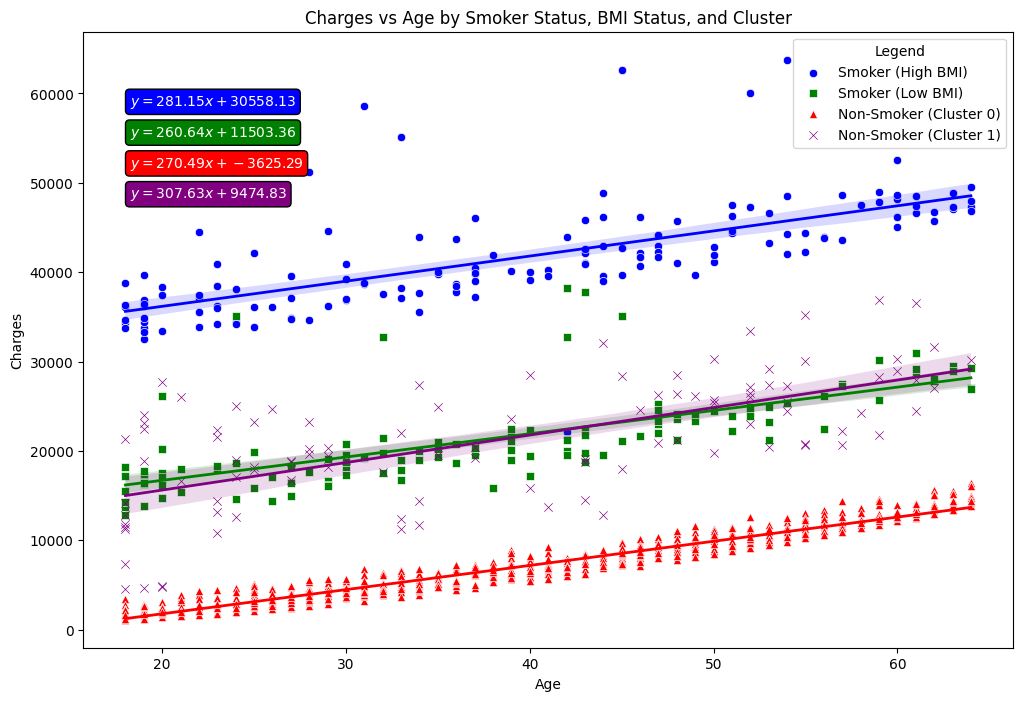

In [29]:
# Split into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Initialize lists to store predictions and actual values
train_predictions = []
train_actuals = []
test_predictions = []
test_actuals = []

# Define a function to fit linear regression and aggregate predictions
def fit_and_aggregate_predictions(df, condition):
    X_train = train_df[train_df.apply(condition, axis=1)][['age']]
    y_train = train_df[train_df.apply(condition, axis=1)]['charges']
    
    if len(X_train) == 0 or len(y_train) == 0:
        return None, None
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    
    # Aggregate predictions and actual values for training set
    train_predictions.extend(y_pred_train)
    train_actuals.extend(y_train)
    
    # Predict on test set
    X_test = test_df[test_df.apply(condition, axis=1)][['age']]
    y_test = test_df[test_df.apply(condition, axis=1)]['charges']
    y_pred_test = model.predict(X_test)
    
    # Aggregate predictions and actual values for test set
    test_predictions.extend(y_pred_test)
    test_actuals.extend(y_test)
    
    return model

# Fit models and aggregate predictions
conditions = [
    (lambda x: x['cluster'] == -1 and x['smoker'] == 'yes' and x['bmi_status'] == 'high'),
    (lambda x: x['cluster'] == -1 and x['smoker'] == 'yes' and x['bmi_status'] == 'low'),
    (lambda x: x['cluster'] == 0 and x['smoker'] == 'no'),
    (lambda x: x['cluster'] == 1 and x['smoker'] == 'no')
]

for condition in conditions:
    model = fit_and_aggregate_predictions(train_df, condition)

# Calculate RMSE, MAE, and R-squared for training set
rmse_train = mean_squared_error(train_actuals, train_predictions, squared=False)
mae_train = mean_absolute_error(train_actuals, train_predictions)
r2_train = r2_score(train_actuals, train_predictions)

# Calculate RMSE, MAE, and R-squared for testing set
rmse_test = mean_squared_error(test_actuals, test_predictions, squared=False)
mae_test = mean_absolute_error(test_actuals, test_predictions)
r2_test = r2_score(test_actuals, test_predictions)

# Print results
print("Training Metrics:")
print(f"RMSE: {rmse_train:.2f}")
print(f"MAE: {mae_train:.2f}")
print(f"R^2: {r2_train:.2f}")
print()
print("Testing Metrics:")
print(f"RMSE: {rmse_test:.2f}")
print(f"MAE: {mae_test:.2f}")
print(f"R^2: {r2_test:.2f}")

Training Metrics:
RMSE: 2381.39
MAE: 1285.60
R^2: 0.96

Testing Metrics:
RMSE: 2746.41
MAE: 1278.98
R^2: 0.95


# Step 12: Conclusion and Understanding

## Data Understanding and Problem Statement:

* Analyzed features including age, sex, BMI, children, smoker status, and region to predict medical insurance charges.

## Feature Relationships:

* Identified smoker status as a critical predictor due to distinct charge distributions.
* BMI showed varying relationships with charges based on smoker status.
* Modeling Results:

## Decision Tree:
* Higher variance and lower bias model.
* Identified important features: smoker, BMI, and age.
* RMSE: Train ~ 4198, Test ~ 4512.

## Random Forest:
* Lower train RMSE (~1911) compared to Decision Tree.
* Similar test RMSE (~4590) to Decision Tree.
* Showed variability in feature importance across trees.

## Insights from Data Exploration:

* Discovered clusters in charge vs feature plots, suggesting hidden variables or interactions.
* New cluster feature significantly improved model performance.

## Prediction Intervals:

* Utilized mean predictions and standard errors to create prediction intervals, visualizing uncertainty in model predictions.

## Further Analysis:

* Applied grouped linear regression by BMI and cluster to explore charge variations, confirming insights from previous models.

In [30]:
# I tried to fit an oblique decision tree, which was also giving pretty good results. 
# but unfortunately, it is not working in kaggle
# but it was working in Google Colab
# I am writing the code for future reference
################################################################

# df = pd.read_csv('/kaggle/input/ushealthinsurancedataset/insurance.csv')

# # Categorical and numerical features
# categorical_features = ['sex', 'smoker', 'region']
# numerical_features = ['age', 'bmi', 'children']

# transformer = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(), categorical_features)
#     ],
#     remainder='passthrough'  # Keep numerical features as is
# )

# # Transform the features
# # Features and target variable
# X = transformer.fit_transform(df.drop('charges', axis=1))
# y = df['charges']

# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# # installing the package
# git clone https://github.com/hengzhe-zhang/scikit-obliquetree.git

# %cd scikit-obliquetree # moving to the proper folder
# from scikit_obliquetree.HHCART import HouseHolderCART
# from scikit_obliquetree.segmentor import MSE, MeanSegmentor
# from sklearn.ensemble import BaggingRegressor
# from sklearn.model_selection import cross_val_score

# oblique_tree = HouseHolderCART(MSE(), MeanSegmentor(), max_depth=5)
# bagging_model = BaggingRegressor(oblique_tree, n_estimators=100, n_jobs=-1, random_state=42)
# bagging_model.fit(X_train, y_train)
# # Predict on the training and testing sets
# y_pred_train = bagging_model.predict(X_train)
# y_pred_test = bagging_model.predict(X_test)

# # Evaluate the model
# rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print(f'Training RMSE: {rmse_train}')
# print(f'Testing RMSE: {rmse_test}')